In [1]:
import numpy as np
import scipy
from qutip import *
from numba import jit, njit
from scipy.signal import find_peaks, peak_widths

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

from mpl_toolkits.mplot3d import Axes3D
from plotly.offline import plot
import plotly.graph_objs as go

In [38]:

arr_gS = 2*np.pi * np.array([.0,.0,.0,.0])
arr_gS_rho = []

for indxS, gS2 in enumerate(arr_gS):
    
    gS = 2*np.pi*30
    gAS = 2*np.pi*30
    gA2 = 2*np.pi*0
    gS2 = 2*np.pi*0
    gTHz = 2*np.pi*0

    gamma_opt = 2*np.pi * 0.04    #frequencies in GHz
    Delta_opt = 2*np.pi * 0.
    kappa_opt = 2*np.pi * .0

    gamma_v = 2*np.pi * 10
    Delta_v = 2*np.pi * 0
    n_th = 0
    kappa_v = 2*np.pi * .0

    Nvib = 50
    sig = tensor( sigmam(), qeye(Nvib))
    b = tensor(qeye(2), destroy(Nvib))
    
    eta = 0.3
    sig_p = sig * tensor(qeye(2), displace(Nvib, eta))  

    gAS_incoh = 2*np.pi * 0.0
    Gamma_plus = gAS_incoh**2/(gamma_v) 

    Om_opt = 2*np.pi * 0.
    Om_THz =  2*np.pi * 0.

    T_v = 2*np.pi/gamma_v*0+.1
    
    eff_shift = 2*np.pi * 0

    theta = np.pi/2 * .0
    H0 = Delta_v*b.dag()*b + Delta_opt*sig.dag()*sig + Om_opt/2*( sig + sig.dag() ) + eff_shift* (b.dag() * b) * sig.dag()*sig #+ Om_THz*( np.exp(1j*theta)*b + np.exp(-1j*theta)*b.dag() )
    #H0 = 2*np.pi *4*b.dag()*b + Delta_opt*sig.dag()*sig + Om_opt/2*( sig*b + sig.dag()*b.dag() )     #anti-Stokes pump for stimulated Raman

    H_S = gS/2.*( sig*b.dag() + sig.dag()*b )
    H_AS = gAS/2.*( sig*b + sig.dag()*b.dag() )
    HR_2 = eta/2*gS2 /2.*( sig.dag()*b*b + sig*b.dag()*b.dag() )
    HAR_2 = eta/2*gA2 /2.*( sig.dag()*b.dag()*b.dag() + sig*b*b )

    H = H0 + H_S + H_AS + (HR_2 + HAR_2) + gTHz/2.*(b+b.dag())
    c_jumps = [ np.sqrt(gamma_v*(1 + n_th))*b, np.sqrt(gamma_v*(n_th))*b.dag(), np.sqrt(kappa_v)*b.dag()*b, np.sqrt(gamma_opt)*sig, np.sqrt(Gamma_plus)*sig.dag(), np.sqrt(kappa_opt)*sig.dag()*sig ]

    rho_ss = steadystate(H, c_jumps)
    
    c = sig #*eta *b.dag()

    arr_gS_rho.append( rho_ss )


In [39]:
arr_W = []
for rho_gS in arr_gS_rho:
    xvec = np.linspace(-4, 4, 400)
    #W = wigner( (sig.dag()*sig*rho_gS*sig.dag()*sig).ptrace(1), xvec, xvec )
    W = wigner( (rho_gS).ptrace(1), xvec, xvec )
    arr_W.append( W )


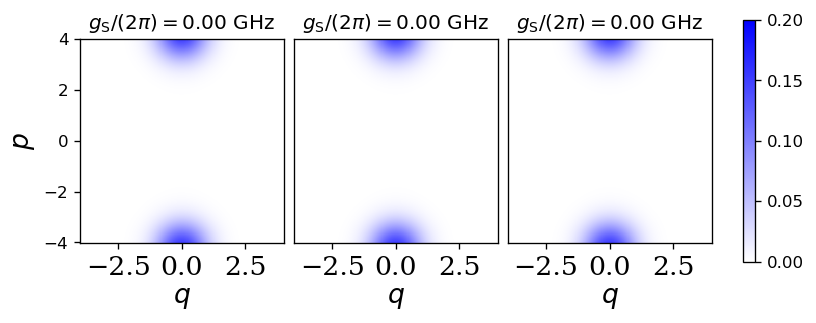

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
# Font configuration
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}

font2 = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 12,
}

# Custom colormap: White to Blue
custom_cmap = LinearSegmentedColormap.from_list('white_to_blue', [(1, 1, 1), (0, 0, 1)])  # White to Blue
# Initialize figure for side-by-side plots
fig, axes = plt.subplots(1, 3, dpi=120, figsize=(15, 5), constrained_layout=True)

X, Y = np.meshgrid(xvec, xvec)
# Normalize colormap around 0
norm = Normalize(vmin=0, vmax=0.2)

# Plot the last three elements of arr_W
for i, ax in enumerate(axes):
    idx = -3 + i  # Last three indices
    W = arr_W[idx]  # Select the corresponding matrix
    wigner_plot = ax.pcolormesh(X, Y, W, cmap=custom_cmap, shading='auto', norm=norm)
    
    # Set x-labels
    ax.set_xlabel(r'$q$', fontdict=font)
    
    # Set y-label only for the first plot
    if i == 0:
        ax.set_ylabel(r'$p$', fontdict=font)
    else:
        ax.set_ylabel(None)
        ax.tick_params(axis='y', left=False, labelleft=False)  # Remove ticks and labels for y-axis

    # Set aspect ratio and title
    ax.set_aspect('equal')
    ax.set_title(r'$g_{\rm S}/(2\pi)=$%.2f GHz' % (arr_gS[idx]/(2*np.pi)), fontsize=font2['size'])
    ax.tick_params(axis='x', labelsize=font['size'])
    plt.setp(ax.get_xticklabels(), fontname=font['family'], weight=font['weight'], color=font['color'])

# Add a single colorbar to the last axis
cbar = fig.colorbar(wigner_plot, ax=axes, orientation='vertical', shrink=0.8, location='right')
#cbar.set_label(r'Wigner Function $W(q, p)$', fontdict=font)

# Display the figure

plt.gcf().set_size_inches(170 / 25.4, 70 / 25.4)
#plt.savefig('wigner_gAS15.png', dpi=300)

plt.show()

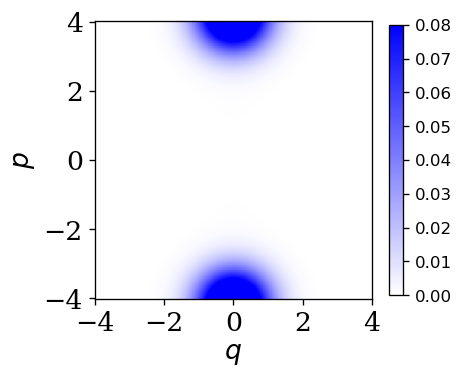

In [41]:
from matplotlib.colors import Normalize
from matplotlib.animation import FuncAnimation
from matplotlib import cm
from IPython.display import HTML

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

# Initialize figure for Wigner function animation
fig_w, ax_w = plt.subplots(dpi=120, figsize=(5, 5))
#xvec = np.linspace(-2, 2, 200)
X, Y = np.meshgrid(xvec, xvec)
#W = wigner(arr_rho_ss[0].ptrace(1), xvec, xvec)
#W = wigner(arr_rho_up[0], xvec, xvec)
W = arr_W[0]

# Normalize the colormap around 0
#norm = Normalize(vmin=np.min(W.real)/10, vmax=np.max(W.real)/10 )
custom_cmap = LinearSegmentedColormap.from_list('white_to_blue', [(1, 1, 1), (0, 0, 1)])  # White to Blue
norm = Normalize(vmin=0, vmax=.08 )

# Create the pcolormesh plot
wigner_plot = ax_w.pcolormesh(X, Y, W, cmap=custom_cmap, shading='auto', norm=norm)

# Add the color bar
cbar = fig_w.colorbar(wigner_plot, ax=ax_w, orientation='vertical', shrink=0.8)
#cbar.set_label(r'Wigner Function $W(x, p)$', fontdict=font)

# Set labels and aspect ratio
ax_w.set_xlabel(r'$q$',fontdict=font)
ax_w.set_ylabel(r'$p$', fontdict=font)
ax_w.set_aspect('equal')

plt.xticks(fontsize=font['size'], fontname=font['family'], weight=font['weight'], color=font['color'])
plt.yticks(fontsize=font['size'], fontname=font['family'], weight=font['weight'], color=font['color'])

#plt.grid()
plt.gcf().set_size_inches(100 / 25.4, 90 / 25.4)
plt.tight_layout()

#plt.savefig('wigner_parity.png', dpi=300)